In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
# Change this if using cov matrix (or to keep the adjacency matrix)
is_cov = True

# Keep data in 2D for 2D convolution of the NN
def load_graphs(input_dir, class_dict) :

    data, data_labels = [], [] # data containing the graphs and data_labels the associated seizure type labels
    i=0
    for szr_type in class_dict.keys() :
        szr_label = class_dict[szr_type]
        for _, _, files in os.walk(os.path.join(input_dir,szr_type)) :
            for npy_file in files :
                A = np.load(os.path.join(input_dir,szr_type,npy_file))

                # Normalise A (already normalised depending on the input)
                A = A/np.amax(A.flatten())
                if is_cov : 
                    L = A
                else : 
                    L = np.diag(A*np.ones((A.shape[0],1)))-A
                
                #L = L[np.triu_indices(20, k = 1)]
                L = np.triu(L, 1)
                L = torch.tensor(L).view(1,20,20)

                data.append(L)
                data_labels.append(szr_label)

    return np.array(data), np.array(data_labels)

def train_test_data(input_dir, class_dict) :

    train, train_labels = load_graphs(os.path.join(input_dir,'train'), class_dict)
    test, test_labels = load_graphs(os.path.join(input_dir,'dev'), class_dict)

    return train, test, train_labels, test_labels

In [3]:
# Need to put it as a torch.Size([1, 20, 20])
#input_dir = '../data/v1.5.2/graph_unnormal'
#input_dir = '../data/v1.5.2/graph_cov_low'
input_dir = '../data/v1.5.2/graph_avg_1_5'
szr_types = ['FNSZ','GNSZ']

class_dict = {}
for i, szr_type in enumerate(szr_types) :
    class_dict[szr_type] = i

train, test, train_labels, test_labels = train_test_data(input_dir, class_dict)

C:\Users\rapha\AppData\Local\Temp/ipykernel_21020/2064234127.py:29: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(data), np.array(data_labels)
C:\Users\rapha\AppData\Local\Temp/ipykernel_21020/2064234127.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), np.array(data_labels)


In [4]:
# Oversampling (train set only) to have balanced classification without dropping information
PD = pd.DataFrame(train_labels,columns=['label'])
no_0, no_1 = len(PD[PD['label']==0]), len(PD[PD['label']==1])
print(no_0, ' vs ', no_1)

R = math.floor(no_0/no_1)
print(R) # Multiply the dataset by this ratio, then add (no_0 - R*no_1) randomly selected entries from the smallest dataset
print(no_0 - R*no_1)

1536  vs  409
3
309


In [5]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset, testset = [], []
for i in range(len(train)) :
    if train_labels[i] == 1 : # Under-represented class :
        # The dataloader later shuffles the data
        for r in range(R) :
            trainset.append((train[i],train_labels[i]))
    else :
        trainset.append((train[i],train_labels[i]))

# Compensate the remaining imbalance => draw (no_0 - R*no_1) elements from already present elements
Add = random.sample(PD[PD['label']==1].index.to_list(),no_0 - R*no_1)
for idx in Add :
    trainset.append((train[idx],train_labels[idx]))

for j in range(len(test)) :
    testset.append((test[j],test_labels[j]))
    
classes = ('FNSZ','GNSZ')

#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
len(trainset)
tmp_set = []
for s in trainset :
    tmp_set.append(s[1])

PD_tmp = pd.DataFrame(tmp_set,columns=['label'])
tmp_0, tmp_1 = len(PD_tmp[PD_tmp['label']==0]), len(PD_tmp[PD_tmp['label']==1])
print(tmp_0, ' vs ', tmp_1)

1536  vs  1536


In [42]:
"""
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=1)
"""
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 2)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=1)

In [43]:
# Run forward pass once and check flattened output dimensions
CNN = Net()
CNN = CNN.float()
print(CNN)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)


In [44]:
gamma = 1e-4
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN.parameters(), lr=gamma)

In [45]:
total_L, total_acc = [], []
print('Batch_size : ',batch_size,'\nLearning rate : ',gamma)
for epoch in range(5): 
    i = 0
    temp_L = []

    correct = 0
    total = 0
    for data in trainloader:
        X, y = data
        optimizer.zero_grad()
        X, y = X.float(), y.type(torch.LongTensor)
        output = CNN(X)

        loss = loss_criterion(output, y)
        loss.backward()
        optimizer.step() 
        temp_L.append(loss)

        i += 1
    total_L.append(sum(temp_L)/float(len(temp_L)))
    print(f"Epoch : {epoch}, Loss : {round(total_L[-1].item(),6)}")
    #print('Accuracy of the network on the train graphs : %d %%' % (100 * correct / total))


Batch_size :  50 
Learning rate :  0.0001
Epoch : 0, Loss : 0.693102
Epoch : 1, Loss : 0.692802
Epoch : 2, Loss : 0.692287


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002CE744E1550>
Traceback (most recent call last):
  File "C:\Users\rapha\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\Users\rapha\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch : 3, Loss : 0.691403
Epoch : 4, Loss : 0.689974
Epoch : 5, Loss : 0.687197
Epoch : 6, Loss : 0.682599
Epoch : 7, Loss : 0.674572
Epoch : 8, Loss : 0.663092
Epoch : 9, Loss : 0.64596
Epoch : 10, Loss : 0.626189
Epoch : 11, Loss : 0.608394
Epoch : 12, Loss : 0.594122
Epoch : 13, Loss : 0.58459
Epoch : 14, Loss : 0.57497
Epoch : 15, Loss : 0.566462
Epoch : 16, Loss : 0.561477
Epoch : 17, Loss : 0.554688
Epoch : 18, Loss : 0.551764
Epoch : 19, Loss : 0.547209
Epoch : 20, Loss : 0.544541


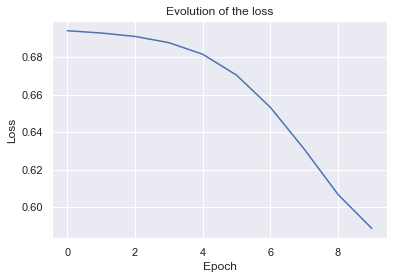

In [ ]:
import seaborn as sns

L_2 = [T.detach().numpy() for T in total_L]

L_2 = np.array(L_2)

plt.figure()

sns.set()
plt.plot(L_2)
plt.title('Evolution of the loss')
plt.xlabel('Epoch');plt.ylabel('Loss');

In [ ]:
correct = 0
total = 0

images = []
y_pred, y_true = [], []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        X_test, labels = data
        X_test, labels = X_test.float(), labels.type(torch.LongTensor)
        # calculate outputs by running images through the network
        outputs = CNN(X_test)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        images.extend([x.detach().numpy() for x in X_test])
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

TOT_ACC = 100 * correct / total
F1 = 100 * f1_score(y_true, y_pred, average='weighted')

print('Accuracy on test : %d %%' % (TOT_ACC))
print('Weighted F1-score on test : %d %%' % (F1))


Accuracy on test : 64 %
Weighted F1-score on test : 65 %


In [13]:
# prepare to count predictions for each class
classes = ('FNSZ','GNSZ')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        X_test, labels = data
        X_test, labels = X_test.float(), labels.type(torch.LongTensor)
        outputs = CNN(X_test)
        _, predictions = torch.max(outputs, 1)
        
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [14]:
print('Final loss : ',round(total_L[-1].item(),6))
print(f'Unweighted total accuracy on test : {round(TOT_ACC,1)} %')
print(f'Weighted F1-score on test : {round(F1,1)} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for {:5s} is: {:.1f} %".format(classname, accuracy))

Final loss :  0.588593
Unweighted total accuracy on test : 64.8 %
Weighted F1-score on test : 65.1 %
Accuracy for FNSZ  is: 68.7 %
Accuracy for GNSZ  is: 58.0 %


In [15]:
import shap

In [31]:
"""
testloader_copy = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=True, num_workers=2)
batch = next(iter(testloader_copy)) # testloader has not been shuffled
images, im_labels = batch
"""

# Turn the list to a tensor
images = torch.tensor(np.array(images))

# Find matching indices between y_true and y_pred and only pick test images amongst those 
idx = [i for i in range(len(y_true)) if y_true[i]==y_pred[i]]

# Might need to shuffle them after that or succeeding samples will be from same recording and very similar

# Compute shap_values on all background, and then only plot some rightly classified with shap_numpy (randomly selected)
# Retrieve each classes shap values and find a way to rank pixels according to their contribution to the class
# FNSZ_shaps = shap_numpy[0].reshape((len(test_images), 20, 20))
# GNSZ_shaps = shap_numpy[1].reshape((len(test_images), 20, 20))

background = images[idx] # IMBALANCED !

tries = random.sample(idx, 5)
test_images = images[tries]

e = shap.DeepExplainer(CNN, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [32]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [34]:
classess = ['FNSZ','GNSZ']
im_names = np.vectorize(lambda x : classess[x])([y_true[j] for j in tries]).tolist()
# Add im_namees text to the left of the figure
labels = np.array(len(test_images)*[classess])

In [35]:
FNSZ_shaps = shap_numpy[0].reshape((len(test_images), 20, 20))
GNSZ_shaps = shap_numpy[1].reshape((len(test_images), 20, 20))

['FNSZ', 'FNSZ', 'FNSZ', 'FNSZ', 'FNSZ']


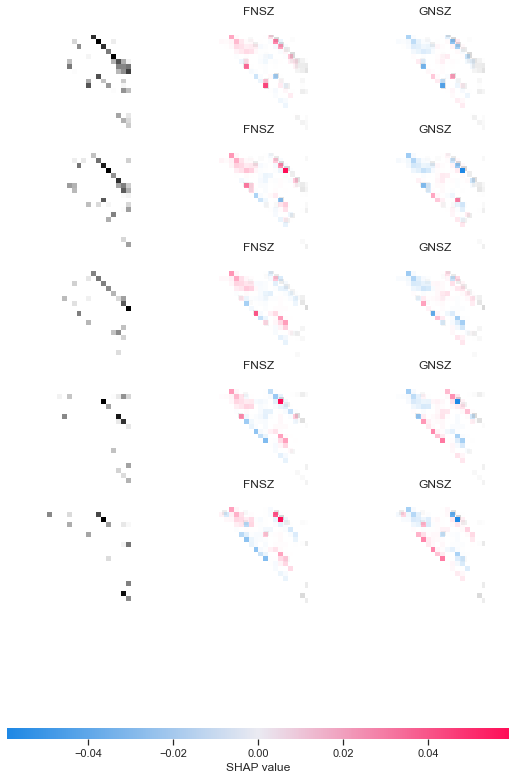

In [36]:
# plot the feature attributions
print(im_names)
shap.image_plot(shap_numpy, -test_numpy, labels=labels, labelpad=20)

# Identify which ax represents which class (and also try to test on images that were positively classified,
# or there will be more red than blue on both times for the same class)